In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from joblib import dump, load

In [3]:
uploaded = files.upload()

Saving readysetbet.py to readysetbet.py


In [4]:
from readysetbet import ReadySetBetGame

In [5]:
def create_race_dataframe(all_race_data):
    """
    Convert race data into a tidy DataFrame.

    Parameters:
    all_race_data (list): List of dictionaries containing race data.

    Returns:
    pd.DataFrame: A tidy DataFrame containing race data.

    """
    # Initialize an empty list to store race data
    race_dataframe_list = []

    # Iterate through each race data with race_id
    for race_id, race in enumerate(all_race_data, start=1):

        # Initialize roll number for each race
        roll_number = 0

        # Iterate through each step data in the race
        for step_data in race:

            # Add race_id to step_data dictionary
            step_data['race_id'] = race_id

            # Transform positions dictionary into separate columns for each horse
            for horse, position in step_data['positions'].items():
                step_data[f'horse_{horse}'] = position

            # Extract the horse eligible for the bonus in this step
            bonus_horses = [horse for horse, bonus in step_data['bonus'].items() if bonus]
            bonus_horse = bonus_horses[0] if bonus_horses else '0'

            # Add bonus and bonus_value columns
            step_data['bonus'] = bonus_horse
            step_data['bonus_value'] = game.stable.horses[bonus_horse].bonus if bonus_horse != '0' else 0

            # Convert bonus horse names to integers
            if bonus_horse == '2/3':
                step_data['bonus'] = 23
            elif bonus_horse == '11/12':
                step_data['bonus'] = 1112
            else:
                step_data['bonus'] = int(bonus_horse)

            # Increment roll number for each step
            roll_number += 1

            # Add roll_number column to step_data dictionary
            step_data['roll_number'] = roll_number

            # Append the updated step_data dictionary to race_dataframe_list
            race_dataframe_list.append(step_data)

    # Create a DataFrame from the race_dataframe_list
    race_dataframe = pd.DataFrame(race_dataframe_list)

    # Reorganize columns as per the specified order
    columns_order = ['race_id', 'step', 'roll', 'roll_number'] + [f'horse_{horse}' for horse in game.stable.horses.keys()] + ['bonus', 'bonus_value']
    race_dataframe = race_dataframe[columns_order]

    return race_dataframe

In [6]:
num_races = 10000
all_race_data = []
count = 0

for _ in range(num_races):
    game = ReadySetBetGame()
    count += 1
    game.play_game()
    all_race_data.append(game.get_race_data())
    if count % 1000 == 0:
      print(f"{count} races ran")


# Create DataFrame from all race data
df = create_race_dataframe(all_race_data)

1000 races ran
2000 races ran
3000 races ran
4000 races ran
5000 races ran
6000 races ran
7000 races ran
8000 races ran
9000 races ran
10000 races ran


In [7]:
df.tail(5)

,race_id,step,roll,roll_number,horse_23,horse_4,horse_5,horse_6,horse_7,horse_8,horse_9,horse_10,horse_1112,bonus,bonus_value
639828,10000,55,7,55,3,3,8,14,12,6,3,5,8,7,0
639829,10000,56,3,56,4,3,8,14,12,6,3,5,8,23,3
639830,10000,57,8,57,4,3,8,14,12,7,3,5,8,8,1
639831,10000,58,10,58,4,3,8,14,12,7,3,6,8,10,3
639832,10000,59,6,59,4,3,8,15,12,7,3,6,8,6,1


In [ ]:
# Initialize an empty dictionary to store race results
races = {}
count = 0
# Loop through unique race_ids
for race_id in df['race_id'].unique():
    race = df[df['race_id'] == race_id]
    count += 1

    # Extract horse columns
    horse_columns = [col for col in race.columns if col.startswith('horse_')]

    # Get the last row of the race DataFrame
    result = race[horse_columns].iloc[-1]

    # Determine the winner
    winner = result[result == 15].index[0]
    winner = int(winner.split('_')[1])
    winner_list = [winner for _ in range(race['roll_number'].iloc[-1])]

    # Determine placed horses (top two or tied for top two)
    placed_values = result.nlargest(2, keep='all')
    placed = [int(horse.split('_')[1]) for horse in placed_values.index]
    placed_list = [placed for _ in range(race['roll_number'].iloc[-1])]

    # Determine showed horses (top three or tied for top three)
    showed_values = result.nlargest(3, keep='all')
    showed = [int(horse.split('_')[1]) for horse in showed_values.index]
    showed_list = [showed for _ in range(race['roll_number'].iloc[-1])]

    race['winner'] = winner_list
    race['placed'] = placed_list
    race['showed'] = showed_list

    races[f'race{count}'] = race

df_races_list = [races[race] for race in races]
df_races = pd.concat(df_races_list)

In [9]:
df_races

,race_id,step,roll,roll_number,horse_23,horse_4,horse_5,horse_6,horse_7,horse_8,horse_9,horse_10,horse_1112,bonus,bonus_value,winner,placed,showed
0,1,1,7,1,0,0,0,0,1,0,0,0,0,7,0,6,"[6, 9]","[6, 9, 7]"
1,1,2,11,2,0,0,0,0,1,0,0,0,1,1112,3,6,"[6, 9]","[6, 9, 7]"
2,1,3,10,3,0,0,0,0,1,0,0,1,1,10,3,6,"[6, 9]","[6, 9, 7]"
3,1,4,5,4,0,0,1,0,1,0,0,1,1,5,2,6,"[6, 9]","[6, 9, 7]"
4,1,5,6,5,0,0,1,1,1,0,0,1,1,6,1,6,"[6, 9]","[6, 9, 7]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639828,10000,55,7,55,3,3,8,14,12,6,3,5,8,7,0,6,"[6, 7]","[6, 7, 5, 1112]"
639829,10000,56,3,56,4,3,8,14,12,6,3,5,8,23,3,6,"[6, 7]","[6, 7, 5, 1112]"
639830,10000,57,8,57,4,3,8,14,12,7,3,5,8,8,1,6,"[6, 7]","[6, 7, 5, 1112]"
639831,10000,58,10,58,4,3,8,14,12,7,3,6,8,10,3,6,"[6, 7]","[6, 7, 5, 1112]"


In [10]:
X = df_races.drop(columns=['winner', 'race_id', 'placed', 'showed', 'roll_number'])
y = df_races['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# }

# modelx = xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train_encoded)))

# random_search = RandomizedSearchCV(modelx, param_grid, cv=3, n_iter=50, verbose=1, n_jobs=-1)

# random_search.fit(X_train, y_train_encoded)

In [ ]:
# dump(random_search.best_estimator_, 'best_model.joblib')

In [12]:
model = load('best_model.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.joblib'

In [14]:
preds = model.predict(X_test)
preds = le.inverse_transform(preds)

In [15]:
print("Accuracy: ", accuracy_score(y_test, preds))
print("Precision: ", precision_score(y_test, preds, average='weighted'))
print("Recall: ", recall_score(y_test, preds, average='weighted'))
print("F1 Score: ", f1_score(y_test, preds, average='weighted'))

Accuracy:  0.43891865714776684
Precision:  0.43522379948907397
Recall:  0.43891865714776684
F1 Score:  0.4262321897568331


In [22]:
model_rf = RandomForestClassifier(random_state=42,
                                  verbose=1,
                                  n_estimators=75,
                                  max_depth=40,
                                  n_jobs=-1,
                                  )
model_rf.fit(X_train, y_train_encoded)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.4min finished


RandomForestClassifier(max_depth=40, n_estimators=75, n_jobs=-1,
                       random_state=42, verbose=1)

In [23]:
preds_rf = model_rf.predict(X_test)
preds_rf = le.inverse_transform(preds_rf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    3.0s finished


In [24]:
print("Accuracy: ", accuracy_score(y_test, preds_rf))
print("Precision: ", precision_score(y_test, preds_rf, average='weighted'))
print("Recall: ", recall_score(y_test, preds_rf, average='weighted'))
print("F1 Score: ", f1_score(y_test, preds_rf, average='weighted'))

Accuracy:  0.7485289176115717
Precision:  0.7587805886020907
Recall:  0.7485289176115717
F1 Score:  0.7483939807320993


In [20]:
importances = model_rf.feature_importances_

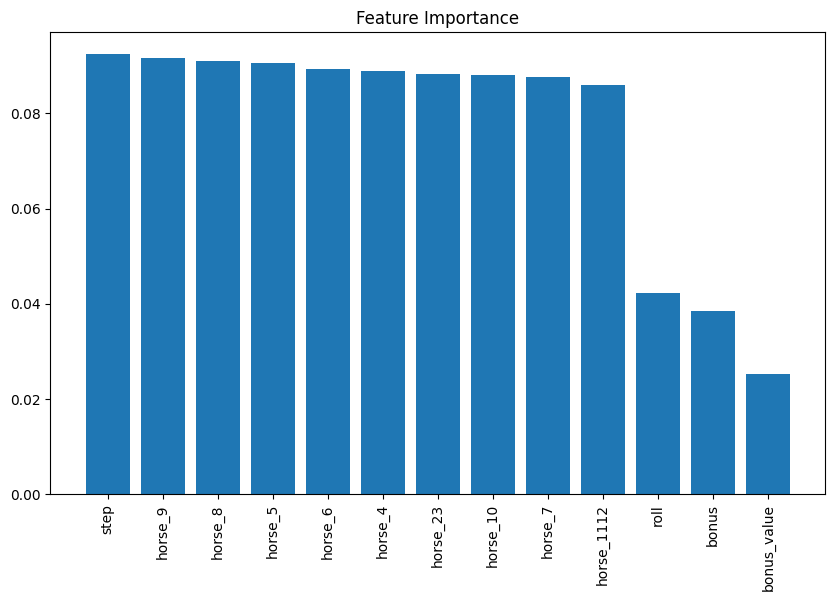

In [21]:
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

In [22]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,step,0.092408
8,horse_9,0.091592
7,horse_8,0.091065
4,horse_5,0.090583
5,horse_6,0.089391
3,horse_4,0.088888
2,horse_23,0.088364
9,horse_10,0.087981
6,horse_7,0.087705
10,horse_1112,0.085940


In [23]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [74]:
len(model_rf.estimators_)

100

In [24]:
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 200],
    'max_depth': [5, 15, 35, 55, 65, 75, 100],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'n_jobs': [-1],
    'random_state': [42]
}

In [ ]:
model_tune = RandomizedSearchCV(model_rf, param_grid, cv=3, n_iter=20, verbose=2, n_jobs=-1, random_state=42)
model_tune.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [25]:
dump(model_rf, 'rf_model.joblib')

['rf_model.joblib']

In [26]:
from google.colab import files

files.download('rf_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>